In [1]:
import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt, patches, colors
from cartopy import crs, feature
from cmocean import cm as cmo

from salishsea_tools import places

In [2]:
plt.rcParams['font.size'] = 9

In [3]:
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
coords = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
spills = pd.read_csv('/data/sallen/results/MIDOSS/Monte_Carlo/northern_strait.csv')

In [20]:
lon, lat = [coords[var][0, ...].values for var in ('glamt', 'gphit')]
tmask = mask.tmask[0, 0, ...].values

In [10]:
# Load ETOPO1 data set
topo = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/ETOPO1_Bed_g_gmt4.grd')

# Crop to Salish Sea
extent = [-126.5, -121.2, 46.8, 51.2]
topo_salishsea = topo.sel(x=slice(*extent[:2]), y=slice(*extent[2:]))
lon, lat, depth = [topo_salishsea[var].values for var in ('x', 'y', 'z')]

In [175]:
# Annotations
annotations_coarse = [
    {'name': 'Pacific\nOcean'     , 'xy': (0.100, 0.200), 'r':   0, 'wt': 'bold', 'arrow': None},
    {'name': 'Puget\nSound'       , 'xy': (0.810, 0.180), 'r':   0, 'wt': 'bold', 'arrow': None},
    {'name': 'Juan de Fuca'       , 'xy': (0.330, 0.305), 'r': -17, 'wt': 'bold', 'arrow': None},
    {'name': 'Strait'             , 'xy': (0.580, 0.304), 'r':   0, 'wt': 'bold', 'arrow': None},
    {'name': 'Johnstone'          , 'xy': (0.025, 0.765), 'r': -20, 'wt': None  , 'arrow': None},
    {'name': 'Strait'             , 'xy': (0.165, 0.690), 'r': -70, 'wt': None  , 'arrow': None},
    {'name': 'Fraser\nRiver'      , 'xy': (0.720, 0.550), 'r':   0, 'wt': None  , 'arrow': None},
    {'name': 'Strait of\nGeorgia' , 'xy': (0.240, 0.520), 'r':   0, 'wt': 'bold', 'arrow': (0.41, 0.55,  0.03,  0.01)},
    {'name': 'Haro\nStrait'       , 'xy': (0.450, 0.380), 'r':   0, 'wt': None  , 'arrow': (0.55, 0.39,  0.04,  0.00)},
    {'name': 'Rosario\nStrait'    , 'xy': (0.770, 0.345), 'r':   0, 'wt': None  , 'arrow': (0.76, 0.37, -0.03,  0.01)},
]

annotations_fine = [
    {'name': 'Discovery\nIslands', 'xy': (0.420, 0.800), 'r': 0  , 'wt': 'bold', 'st': None    , 'c': 'k'},
    {'name': 'Baynes\nSound'     , 'xy': (0.140, 0.340), 'r': 0  , 'wt': 'bold', 'st': None    , 'c': 'k'},
    {'name': 'Jervis\nInlet'     , 'xy': (0.730, 0.700), 'r': 0  , 'wt': 'bold', 'st': None    , 'c': 'k'},
    {'name': 'Malaspina'         , 'xy': (0.480, 0.500), 'r': -25, 'wt': 'bold', 'st': None    , 'c': 'k'},
    {'name': 'Strait'            , 'xy': (0.650, 0.430), 'r': -50, 'wt': 'bold', 'st': None    , 'c': 'k'},
    {'name': 'Quadra I.'         , 'xy': (0.005, 0.850), 'r': -90, 'wt': None  , 'st': 'italic', 'c': 'k'},
    {'name': 'Cortes I.'         , 'xy': (0.205, 0.800), 'r': -80, 'wt': None  , 'st': 'italic', 'c': 'k'},
    {'name': 'Texada I.'         , 'xy': (0.500, 0.440), 'r': -35, 'wt': None  , 'st': 'italic', 'c': 'k'},
    {'name': 'Lasqueti I.'       , 'xy': (0.540, 0.270), 'r': 0  , 'wt': None  , 'st': 'italic', 'c': 'k'},
    {'name': 'Denman I.'         , 'xy': (0.320, 0.420), 'r': 0  , 'wt': None  , 'st': 'italic', 'c': 'k'},
    {'name': 'Hornby I.'         , 'xy': (0.390, 0.380), 'r': 0  , 'wt': None  , 'st': 'italic', 'c': 'k'},
]

communities = [
    {'name': 'Campbell\nRiver', 'lonlat': (-125.248, 50.024), 'label_offset': (-0.03, -0.09)},
    {'name': 'Comox'          , 'lonlat': (-124.902, 49.673), 'label_offset': (-0.17,  0.02)},
    {'name': 'Lund'           , 'lonlat': (-124.762, 49.981), 'label_offset': ( 0.03, -0.02)},
    {'name': 'Nanaimo'        , 'lonlat': (-123.936, 49.164), 'label_offset': (-0.25,  0.00)},
    {'name': 'Parksville'     , 'lonlat': (-124.314, 49.320), 'label_offset': (-0.16, -0.04)},
    {'name': 'Powell\nRiver'  , 'lonlat': (-124.525, 49.835), 'label_offset': ( 0.03, -0.03)},
]

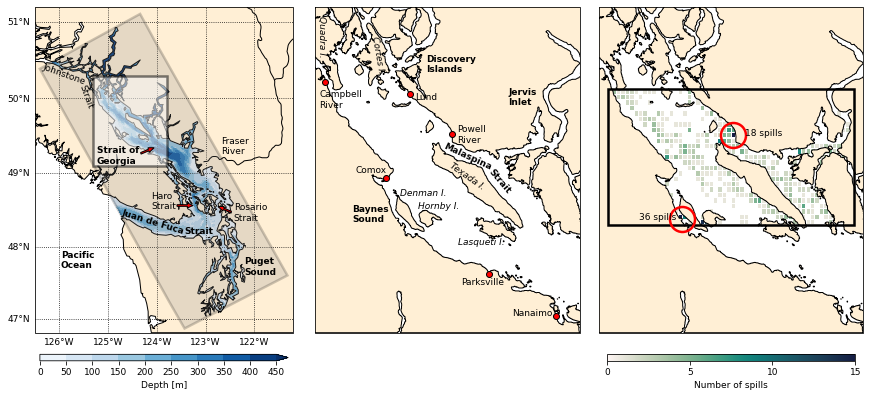

In [182]:
# --------- Figure setup ---------
proj_ref = crs.PlateCarree()
fig = plt.figure(figsize=(15, 6))
gs = plt.GridSpec(1, 3, wspace=0.05)

# --------- Left panel -----------
# Make map
extent = [-126.5, -121.2, 46.8, 51.2]
proj = crs.Mercator(np.mean(extent[:2]), *extent[2:])
ax = fig.add_subplot(gs[0], projection=proj)
ax.set_extent(extent)
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', facecolor='papayawhip'))
ax.add_feature(feature.NaturalEarthFeature(
    category='physical', name='rivers_lake_centerlines',
    scale='10m', facecolor='none', edgecolor='k',
))
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True)
gl.top_labels, gl.right_labels = False, False

# Overlay model domain
domain_box = np.array([(lon[ji], lat[ji]) for ji in [(0, 0), (0, -1), (-1, -1), (-1, 0)]])
c = ax.contourf(lon, lat, bathy.Bathymetry, levels=np.arange(0, 451, 50), cmap='Blues', extend='max', transform=proj_ref)
ax.add_patch(patches.Polygon(domain_box, ec='k', fc='gray', lw=2.5, alpha=0.2, transform=proj_ref, zorder=2))
ax.add_patch(patches.Rectangle((-125.3, 49.1), 1.5, 1.2, fc='w', ec='k', alpha=0.5, lw=2.5, transform=proj_ref, zorder=2))

# Annotations
for ann in annotations_coarse:
    ax.text(*ann['xy'], ann['name'], transform=ax.transAxes, rotation=ann['r'], fontdict={'weight': ann['wt'], 'color': 'k'})
    if ann['arrow'] is not None:
        ax.arrow(*ann['arrow'], width=0.005, head_width=0.015, edgecolor='k', facecolor='r', transform=ax.transAxes, zorder=10)

# Colorbar
cax = fig.add_axes([0.135, 0.06, 0.23, 0.015])
fig.colorbar(c, cax=cax, orientation='horizontal', label='Depth [m]')

# --------- Middle panel ---------
# Make map
extent = [-125.3, -123.8, 49.1, 50.3]
proj = crs.Mercator(np.mean(extent[:2]), *extent[2:])
ax = fig.add_subplot(gs[1], projection=proj)
ax.set_extent(extent)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='papayawhip'))
#ax.contourf(lon, lat, bathy.Bathymetry, levels=np.arange(0, 451, 50), cmap='Blues', extend='max', transform=proj_ref)

# Annotations
for ann in annotations_fine:
    ax.text(*ann['xy'], ann['name'], transform=ax.transAxes, rotation=ann['r'], fontdict={'weight': ann['wt'], 'style': ann['st'], 'color': ann['c']})

# Communities
for community in communities:
    x, y = community['lonlat']
    dx, dy = community['label_offset']
    ax.plot(x, y, 'ro', mec='k', transform=proj_ref)
    ax.text(x+dx, y+dy, community['name'], transform=proj_ref)

# --------- Right panel ----------
# Make map
extent = [-125.3, -123.8, 49.1, 50.3]
proj = crs.Mercator(np.mean(extent[:2]), *extent[2:])
ax = fig.add_subplot(gs[2], projection=proj)
ax.set_extent(extent)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='papayawhip'))

# Plot data
xedges, yedges = np.arange(-125.5, -123.81, 0.025), np.arange(49.5, 50.01, 0.02)
H, _, _ = np.histogram2d(spills.spill_lon.values, spills.spill_lat.values, bins=(xedges, yedges))
c = ax.pcolormesh(xedges, yedges, np.ma.masked_equal(H.T, 0), vmin=0, vmax=15, cmap=cmo.tempo, edgecolors='w', lw=0.01, transform=proj_ref)
ax.add_patch(patches.Rectangle((-125.25, 49.5), 1.4, 0.5, fill=False, ec='k', linewidth=2.5, transform=proj_ref, zorder=2))

# Annotations
ax.plot(-124.83, 49.52, 'ro', ms=25, mew=2.5, fillstyle='none', transform=proj_ref)
ax.plot(-124.54, 49.83, 'ro', ms=25, mew=2.5, fillstyle='none', transform=proj_ref)
ax.text(-125.07, 49.52, '36 spills', transform=proj_ref)
ax.text(-124.47, 49.83, '18 spills', transform=proj_ref)

# Colorbar
cax = fig.add_axes([0.66, 0.06, 0.23, 0.015])
fig.colorbar(c, cax=cax, orientation='horizontal', label='Number of spills', ticks=[0, 5, 10, 15])

#fig.savefig('/home/bmoorema/Desktop/spillmap.png', dpi=200, bbox_inches='tight')